<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

## Prepare Environment

Jupyter notebook housekeeping

In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline


### Install local canswim package

In [17]:
# pip install -r requirements.txt
# !pip install -e ./

import sys
!{sys.executable} -m pip install -e ./


Obtaining file:///home/ivelin/canswim
  Preparing metadata (setup.py) ... done
  Attempting uninstall: canswim
    Found existing installation: canswim 0.0.1
    Uninstalling canswim-0.0.1:
      Successfully uninstalled canswim-0.0.1
  Running setup.py develop for canswim


## Prepare Model

In [7]:
from canswim.model import CanswimModel

canswim_model = CanswimModel()

canswim_model.load_data()


n_test_range_days: 630
min_samples: 1890
n_stocks:  50
n_epochs:  10
Loading saved model


In [52]:
# canswim_model.covariates.load_past_covariates()
# canswim_model.covariates.load_future_covariates()

In [72]:

def prepare_data():
    canswim_model.prepare_data()
    canswim_model.plot_splits()
    canswim_model.plot_seasonality()



Training loop stock subset: ['TBI', 'EXTR', 'BOOM', 'INSM', 'ULTA', 'SKY', 'CCJ', 'LUNA', 'PCH', 'IBRX', 'DHT', 'INFU', 'NWN', 'LZB', 'CNP', 'CPB', 'AGEN', 'MDLZ', 'GPI', 'RM', 'AXP', 'KIM', 'AGYS', 'LAND', 'MDXG', 'ASML', 'SCL', 'CHEF', 'HEAR', 'NYMT', 'MCRI', 'JAKK', 'ALKS', 'CAMT', 'SLG', 'CWST', 'AVAV', 'RSG', 'AMN', 'WAB', 'APPF', 'MSTR', 'AVXL', 'SVC', 'WULF', 'PLAY', 'GTN', 'NOW', 'MODV', 'AZN']
Preparing ticker series for 50 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
self.earnings_loaded_df.columns Index(['eps', 'epsEstimated', 'time', 'revenue', 'revenueEstimated',
       'updatedFromDate', 'fiscalDateEnding'],
      dtype='object')
Added holidays to ticker series.
Preparing train, val, test splits
preparing train, val split for TBI
TBI test_start: 2021-08-23 00:00:00
TBI val_start: 2019-03-25 

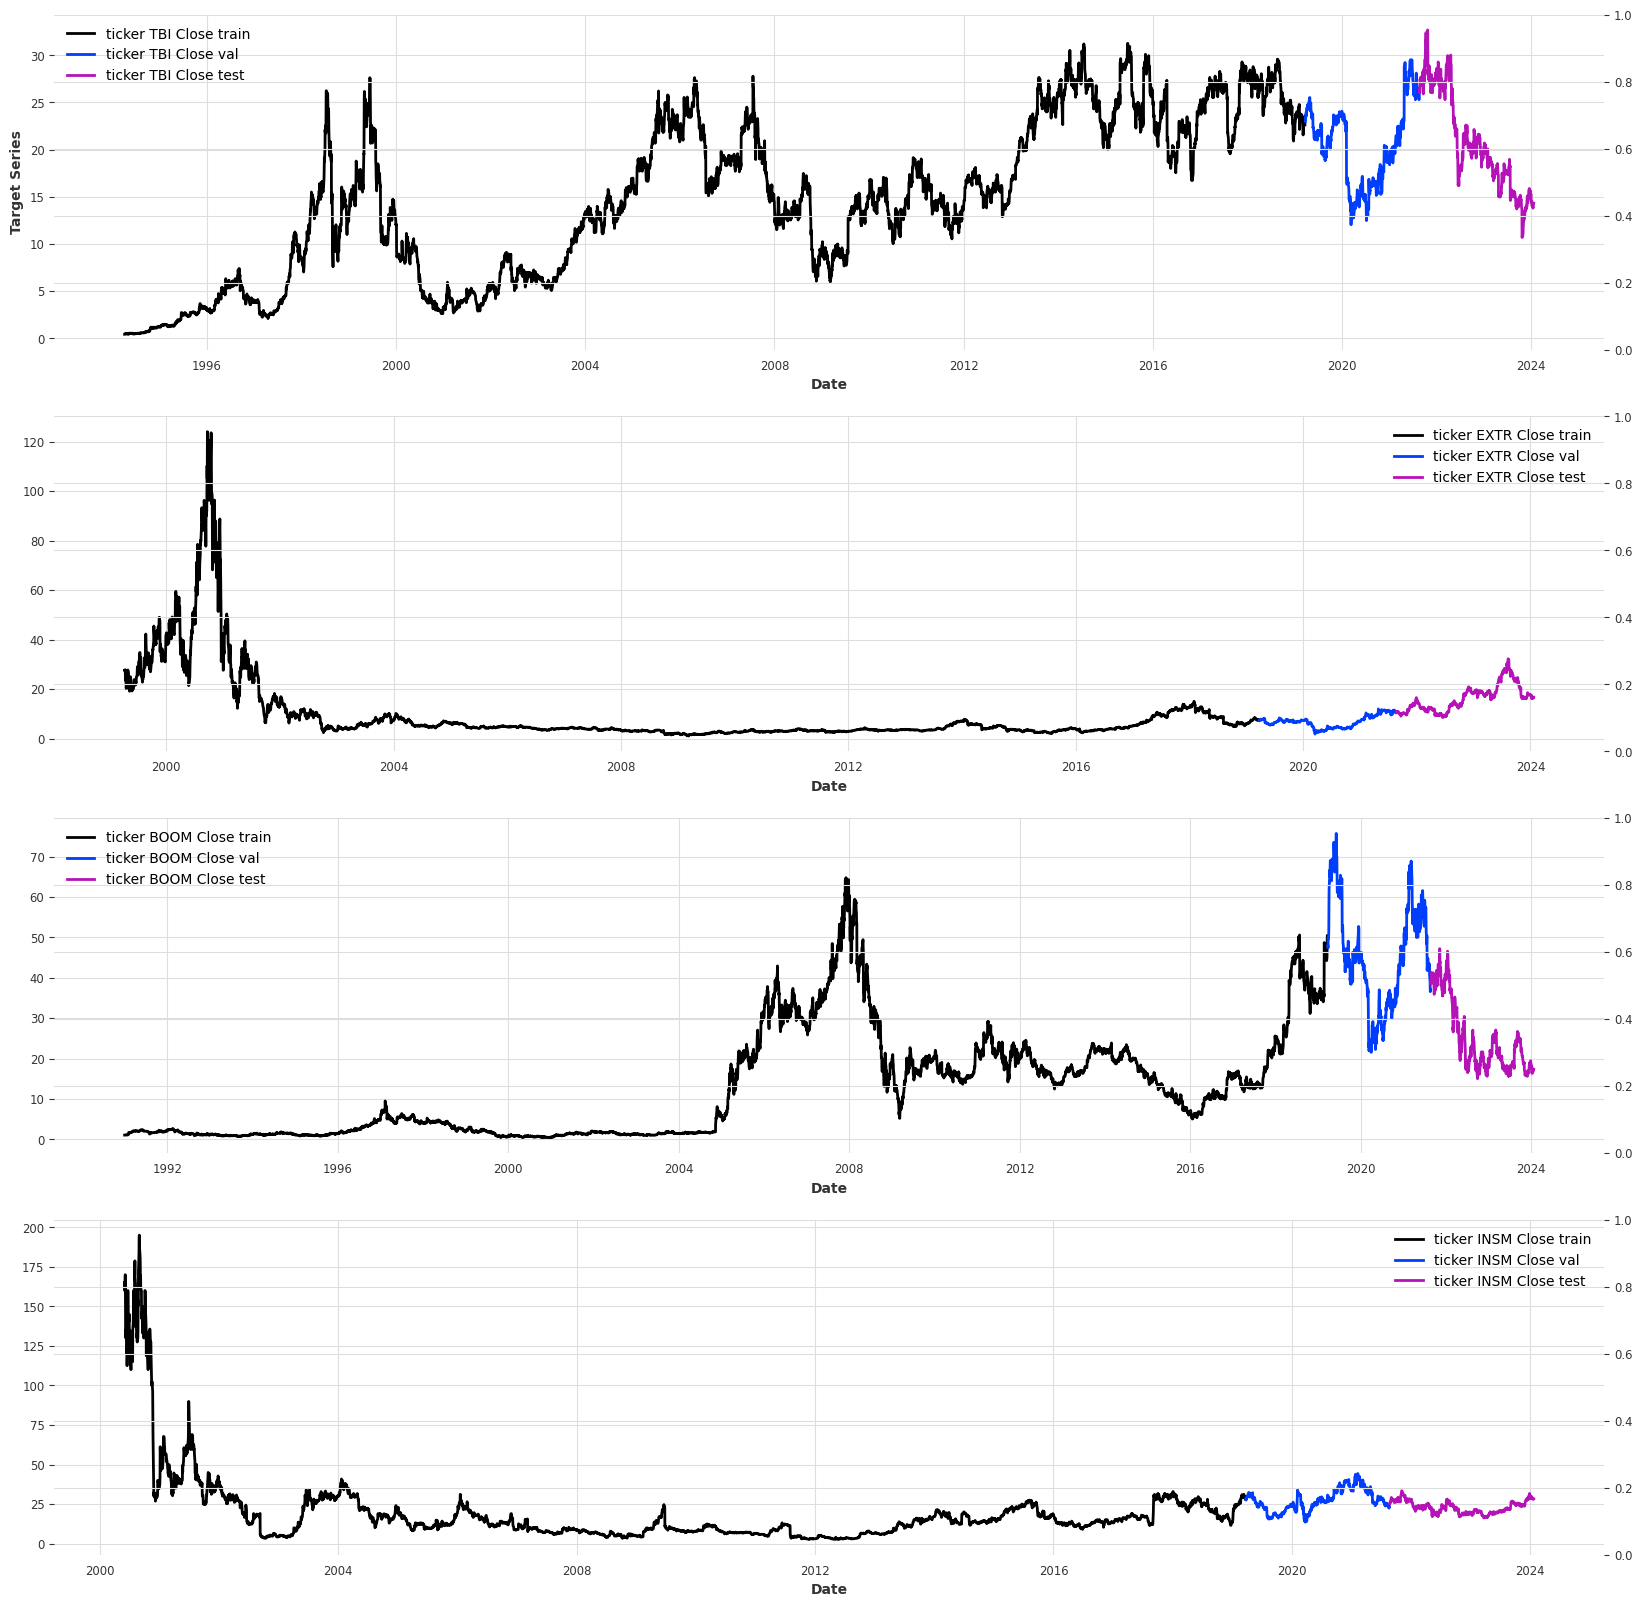

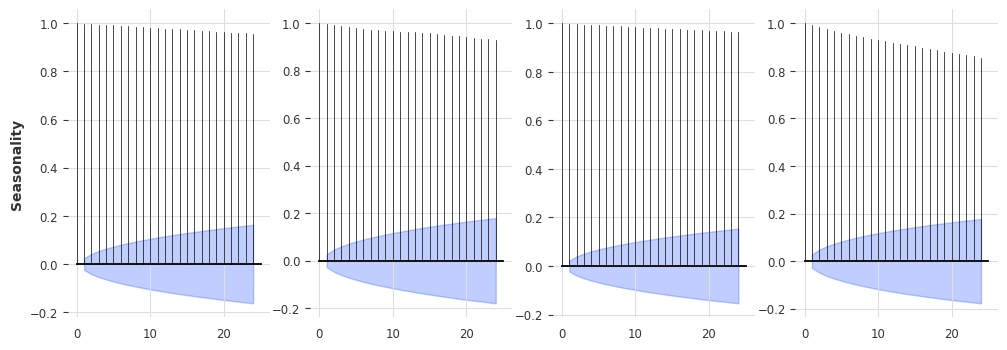

In [73]:
prepare_data()

In [74]:
canswim_model.stock_tickers

['TBI',
 'EXTR',
 'BOOM',
 'INSM',
 'ULTA',
 'SKY',
 'CCJ',
 'LUNA',
 'PCH',
 'IBRX',
 'DHT',
 'INFU',
 'NWN',
 'LZB',
 'CNP',
 'CPB',
 'AGEN',
 'MDLZ',
 'GPI',
 'RM',
 'AXP',
 'KIM',
 'AGYS',
 'LAND',
 'MDXG',
 'ASML',
 'SCL',
 'CHEF',
 'HEAR',
 'NYMT',
 'MCRI',
 'JAKK',
 'ALKS',
 'CAMT',
 'SLG',
 'CWST',
 'AVAV',
 'RSG',
 'AMN',
 'WAB',
 'APPF',
 'MSTR',
 'AVXL',
 'SVC',
 'WULF',
 'PLAY',
 'GTN',
 'NOW',
 'MODV',
 'AZN']

In [76]:
canswim_model.targets.target_series['TBI'].pd_dataframe()

component,Close
Date,
1994-04-04,0.427984
1994-04-05,0.427984
1994-04-06,0.427984
1994-04-07,0.427984
1994-04-08,0.427984
...,...
2024-01-16,13.880000
2024-01-17,13.800000
2024-01-18,14.010000


In [78]:
future_covs = canswim_model.covariates.future_covariates['TBI'].pd_dataframe().tail(500)
past_covs = canswim_model.covariates.past_covariates['TBI'].pd_dataframe().tail(500)

## Find optimal hyper parameters

In [14]:
# if a model has not been selected and saved yet
# run a hyper parameter search
# otherwise load saved model and continue training
if not canswim_model.load_model():
    canswim_model.find_model()
    # canswim_model.build_model(hparams)
    canswim_model.save_model()

## Train model

### Run model training loop

In [15]:

# train loop
for i in range(10):
    # align all data series for training
    canswim_model.train()
    # save model checkpoint
    canswim_model.save()
    # quick test progress at modelcheckpoing
    canswim_model.test()
    canswim_model.plot_test_results()    
    # thorough backtest of model checkpoint
    backtest, test_error = canswim_model.backtest()        
    canswim_model.plot_backtest_results(backtest)    
    print(f"Backtest RMSLE = {test_error}")
    # prepare next sample subset
    prepare_data()


AttributeError: 'CanswimModel' object has no attribute '_CanswimModel__load_model'